In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os

### Preparation Class :

In [19]:
def ImageData_loader(dataset_path, train_name, test_name, one_hot_encode=False):
    train_inputs = []
    train_targets = []
    test_inputs = []
    test_targets = []

    train_class_path = dataset_path + '\\' + train_name
    test_class_path = dataset_path + '\\' + test_name
    train_items = []
    test_items = []
    num_class =0
    for cls in os.listdir(train_class_path):
        num_class += 1
        # x_train
        counter = 0
        current_class = train_class_path + '\\' + cls
        for file in os.listdir(current_class):
            im = img.imread(current_class + '\\' + file)
            im = np.reshape(im,(im.shape[0] * im.shape[1]))
            train_inputs.append(im)
            counter += 1
        train_items.append(counter)
        # x_test
        counter = 0
        current_class = test_class_path + '\\' + cls
        for file in os.listdir(current_class):
            im = img.imread(current_class + '\\' + file)
            im = np.reshape(im,(im.shape[0] * im.shape[1]))
            test_inputs.append(im)
            counter += 1
        test_items.append(counter)

    for cls in range(num_class):
        if one_hot_encode:
            one_hot = np.ndarray([num_class], dtype='int')
            one_hot.fill(0)
            one_hot[cls] = 1
            # y_train
            for i in range(train_items[cls]):
                train_targets.append(one_hot)
            # y_test
            for i in range(test_items[cls]):
                test_targets.append(one_hot)
        else:
            # y_train
            for i in range(train_items[cls]):
                train_targets.append(cls)
            # y_test
            for i in range(test_items[cls]):
                test_targets.append(cls)
            
    return np.array(train_inputs), np.array(train_targets), np.array(test_inputs), np.array(test_targets)

In [20]:
def ImageData_normalize(image):
#     image /= 255
    image *= 2
    image -= 1
    return image

In [21]:
class Data_Spliter():
    def __init__(self, dataset, test_split=0, batch_size=0, validation_split=.0, shuffle=False):
        self.num_samples = dataset[0].shape[0]
        dsIndx = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(dsIndx)
        self.dataset = dataset[0][dsIndx], dataset[1][dsIndx]
        self.num_valid = int(self.num_samples * validation_split)
        self.num_test  = int(self.num_samples * test_split)
        self.num_train = self.num_samples - self.num_test - self.num_valid
        if self.num_valid:
            self.valid_data = self.dataset[0][self.num_train:self.num_train+self.num_valid], self.dataset[1][self.num_train:self.num_train+self.num_valid]
            
        if self.num_test:
            self.test_data = self.dataset[0][self.num_train+self.num_valid::], self.dataset[1][self.num_train+self.num_valid::]
            
        self.train_data = self.dataset[0][0:self.num_train], self.dataset[1][0:self.num_train]
        
        if batch_size == 0:
            self.batch_size = self.num_samples
        else:
            self.batch_size = batch_size

    def train_batchs(self):
        for i in range(0, self.num_train, self.batch_size):
            yield (self.train_data[0][i:i+self.batch_size], self.train_data[1][i:i+self.batch_size]) 
    
    def info(self):
        print('Number of Samples: {}\n| # Train: {} | # Validation: {} | # Test: {}'.format
             (self.num_samples, self.num_train, self.num_valid, self.num_test))

### Model Class :

In [22]:
class NN:
    def __init__(self, layers):
        w1 = np.random.randn(layers[0], layers[1]) / np.sqrt(layers[0])
        w2 = np.random.randn(layers[1], layers[2]) / np.sqrt(layers[1])
        w3 = np.random.randn(layers[2], layers[3]) / np.sqrt(layers[2])
        b1 = np.zeros((1, layers[1]))
        b2 = np.zeros((1, layers[2]))
        b3 = np.zeros((1, layers[3]))
        self.weights= {}
        self.set_weights(w1,b1,w2,b2,w3,b3)
    
    def get_weights(self):
        w1=self.weights['w1']
        b1=self.weights['b1']
        w2=self.weights['w2']
        b2=self.weights['b2']
        w3=self.weights['w3']
        b3=self.weights['b3']
        return w1, b1, w2, b2, w3, b3
    
    def set_weights(self, w1,b1,w2,b2,w3,b3):
        self.weights['w1'] = w1
        self.weights['b1'] = b1
        self.weights['w2'] = w2
        self.weights['b2'] = b2
        self.weights['w3'] = w3
        self.weights['b3'] = b3

    #     @loss.setter
    def loss(self, loss_type):
        self.loss_type = loss_type
    def loss_fun(self, y_hat, y):
        num_sample = y.shape[0]
        if self.loss_type == 'categorical-crossentropy':
            return -np.sum(y * np.log(y_hat)) #/num_sample
        elif self.loss_type == 'sparse-categorical-crossentropy':
            return -np.sum(np.log(y_hat[range(y.shape[0]),y])) # /num_sample
    def d_loss_fun(self, y_hat, y):
        num_sample = y.shape[0]
        if self.loss_type == 'categorical-crossentropy':
            return y_hat - y #/num_sample
        elif self.loss_type == 'sparse-categorical-crossentropy':
            d_loss = y_hat.copy()
            d_loss[range(y.shape[0]), y] -=1
            return d_loss      
    def accuracy_fun(self, y_hat, y):        
        if self.loss_type == 'categorical-crossentropy':
            return (np.argmax(y , axis=1) == np.argmax(y_hat, axis=1))
        elif self.loss_type == 'sparse-categorical-crossentropy':
            return  (y == np.argmax(y_hat, axis=1))
        
    def forward(self, x):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        hidden1 = np.maximum(0, np.dot(x, w1) + b1)
        hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
        linear = np.dot(hidden2, w3) + b3
        normalize_exp = np.exp(linear - np.max(linear))
        y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)
        return y_hat 
    
    def test(self, x, y):
        num_test = x.shape[0]
        y_hat = self.forward(x)
        loss = self.loss_fun(y_hat, y) / num_test
        accuracy = self.accuracy_fun(y_hat, y).mean()
        print('Test Loss: {:.4f}, Accuracy: {:.1f}%'.format(loss, accuracy*100))
    
    def backward(self, Data, epochs, lr, reg_rate=0., verbose=1, trend_plot=False):
        w1, b1, w2, b2, w3, b3 = self.get_weights()
        train_loss = []
        train_accuracy = []
        valid_loss = []
        valid_accuracy = []
        for epoch in range(epochs):   
            iter_loss = 0.
            correct = 0
            iterations = 0    
            for (x, y) in Data.train_batchs():
                iterations +=1
                batch_size = x.shape[0]
                
                hidden1 = np.maximum(0, np.dot(x, w1) + b1)
                hidden2 = np.maximum(0, np.dot(hidden1, w2) + b2)
                linear = np.dot(hidden2, w3) + b3
                normalize_exp = np.exp(linear - np.max(linear))
                y_hat = normalize_exp / np.sum(normalize_exp, axis=1, keepdims=True)

                reg_loss = .5*reg_rate * np.sum(w1*w1) + .5*reg_rate * np.sum(w2*w2) + .5*reg_rate * np.sum(w3*w3)
                delta_loss = self.loss_fun(y_hat, y) + reg_loss
                iter_loss += delta_loss / batch_size 

                d_loss = self.d_loss_fun(y_hat, y)

                d_w3 = np.dot(hidden2.T, d_loss)
                d_b3 = np.sum(d_loss, axis=0, keepdims=True)

                d_hidden2 = np.dot(d_loss, w3.T)
                d_hidden2[hidden2 <=0 ] = 0

                d_w2 = np.dot(hidden1.T, d_hidden2)
                d_b2 = np.sum(d_hidden2, axis=0, keepdims=True)

                d_hidden1 = np.dot(d_hidden2, w2.T)
                d_hidden1[hidden1 <=0 ] = 0

                d_w1 = np.dot(x.T, d_hidden1)
                d_b1 = np.sum(d_hidden1, axis=0, keepdims=True)

                w1 += -lr * (d_w1 + 2*reg_rate * w1)
                b1 += -lr * d_b1
                w2 += -lr * (d_w2 + 2*reg_rate * w2)
                b2 += -lr * d_b2
                w3 += -lr * (d_w3 + 2*reg_rate * w3)
                b3 += -lr * d_b3

                correct += self.accuracy_fun(y_hat, y).sum()
    
            train_loss.append(iter_loss / iterations)
            train_accuracy.append(correct / Data.num_train)

            self.set_weights(w1,b1,w2,b2,w3,b3)

            # validation phase
            valid_inf = ''
            if Data.num_valid:
                x, y = Data.valid_data
                y_hat = self.forward(x)
                loss = self.loss_fun(y_hat, y) / Data.num_valid
                accuracy = self.accuracy_fun(y_hat, y).mean()
                valid_loss.append(loss)
                valid_accuracy.append(accuracy)
            
                valid_inf = ', Validation Loss: {:.4f}, Validation Accuracy :{:.1f}%'.format(valid_loss[-1], 100*valid_accuracy[-1])

            if epoch % verbose == 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Accurecy: {:.1f}% {}'.format
                     (epoch, epochs, train_loss[-1], 100*train_accuracy[-1], valid_inf))

        print('Training Done.')

        if trend_plot:
            plt.figure(figsize=(5,5))
            plt.plot(train_loss, label = 'Trainig Loss')
            plt.plot(valid_loss, label = 'Validation Loss')
            plt.legend()
            plt.show()

            plt.figure(figsize=(5,5))
            plt.plot(train_accuracy, label = 'Trainig Accuracy')
            plt.plot(valid_accuracy, label = 'Validation Accuracy')
            plt.legend()
            plt.show()

## Train Model :

In [23]:
dataset_path = r'C:\Users\Golenaz\Jupyter\Dataset\mnist_png'
train_name = 'training'
test_name = 'testing'

X_train, y_train, X_test, y_test = ImageData_loader(dataset_path, train_name, test_name, one_hot_encode=True)

X_train = ImageData_normalize(X_train)
X_test = ImageData_normalize(X_test)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [25]:
prepared_data = Data_Spliter((X_train, y_train), test_split=0, batch_size=32, validation_split=0, shuffle=True)   
prepared_data.info()

Number of Samples: 60000
| # Train: 60000 | # Validation: 0 | # Test: 0


In [27]:
np.random.seed(1)

nn = NN([784, 128, 32, 10])
nn.loss('categorical-crossentropy')
nn.backward(prepared_data, epochs=10, lr= .001, reg_rate=0.001, verbose=1, trend_plot= True)

Epoch [0/10], Loss: 0.4098, Accurecy: 87.5% 
Epoch [1/10], Loss: 0.1911, Accurecy: 94.3% 
Epoch [2/10], Loss: 0.1402, Accurecy: 95.8% 
Epoch [3/10], Loss: 0.1127, Accurecy: 96.7% 


KeyboardInterrupt: 

In [10]:
nn.test(X_test, y_test)

Test Loss: 2.2892, Accuracy: 11.4%


(10, 784)
-1.0 1.0


array([0, 1, 2, 3, 4, 5, 8, 2, 8, 7], dtype=int64)

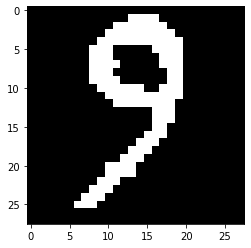

In [19]:
folder_path = r"C:\Users\Golenaz\Desktop\Handwrite"
imgs = []
for f in os.listdir(folder_path):
    file_path = folder_path + '\\' + f
    im = img.imread(file_path)
    temp = np.asarray(im)
    temp = temp[:,:,0]
    temp[temp<.38] = 0
    temp[temp>.38] = 1
    temp = 1-temp
    temp *= 2
    temp -= 1
    temp = temp.reshape(28* 28)
    imgs.append(temp)
    
image = np.stack(imgs)
print(image.shape)

i = 9
print(image[i].min(), image[i].max())
plt.imshow(image[i].reshape(28, 28), cmap='gray')
y_hat = nn.forward(image)
np.argmax(y_hat, axis=1)

NameError: name 'np' is not defined